In [6]:
from IPython.display import Image

## basics

- https://github.com/pytorch/examples/tree/main/distributed/ddp-tutorial-series

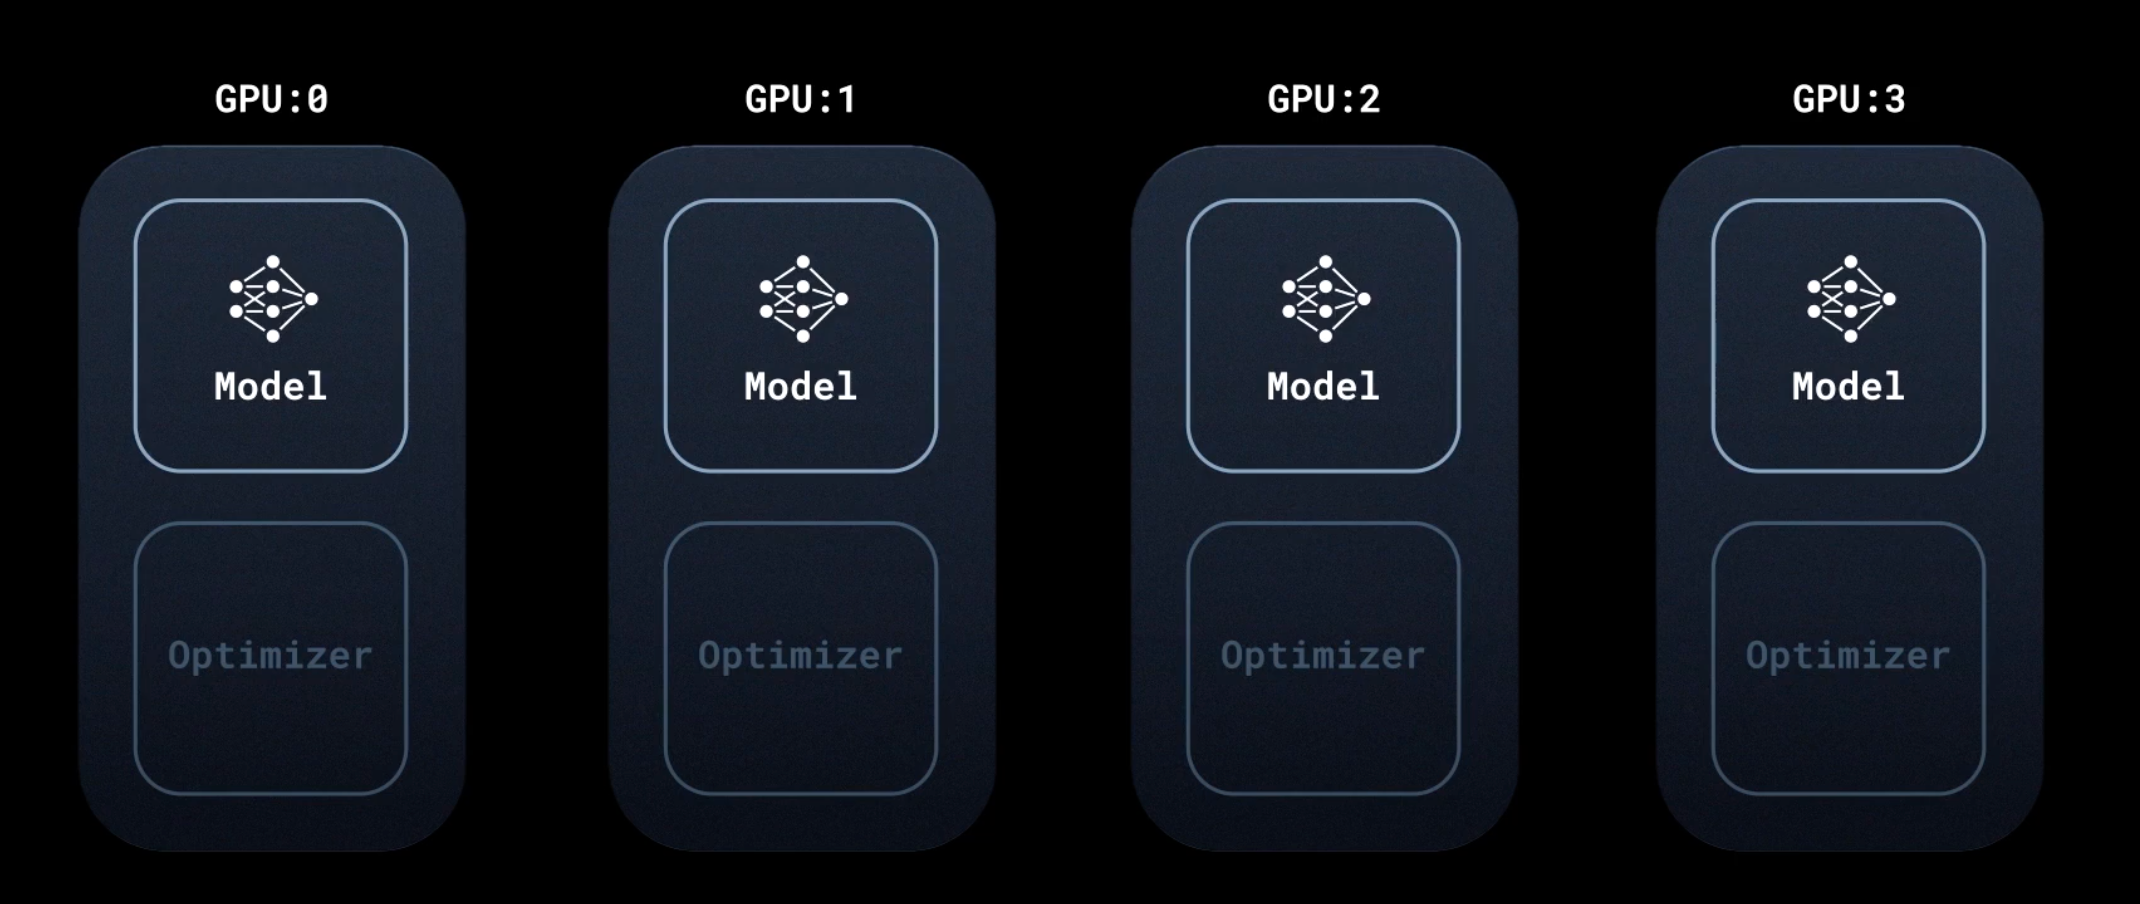

In [3]:
Image('../imgs/gpus.png', width=600)

> multiple GPUs in a single machine/server/node：单机多卡

- 分布式数据并行时，模型（model parameters）/优化器（optimizer states）每张卡都会拷贝一份（replicas）
    - DDP 始终在卡间维持着模型参数和优化器状态的同步一致性在整个训练过程中；
- Data Parallel，batch input，通过 **DistributedSampler** split & 分发到不同的 gpus 上
    - 此时虽然模型/optimizer 相同，但因为数据输入不同，导致 loss 不同，反向传播时计算到的梯度也会不同
    - 此时 ddp 如何保证卡间，model/optimizer 的同步一致性呢
        - ring all-reduce algorithm


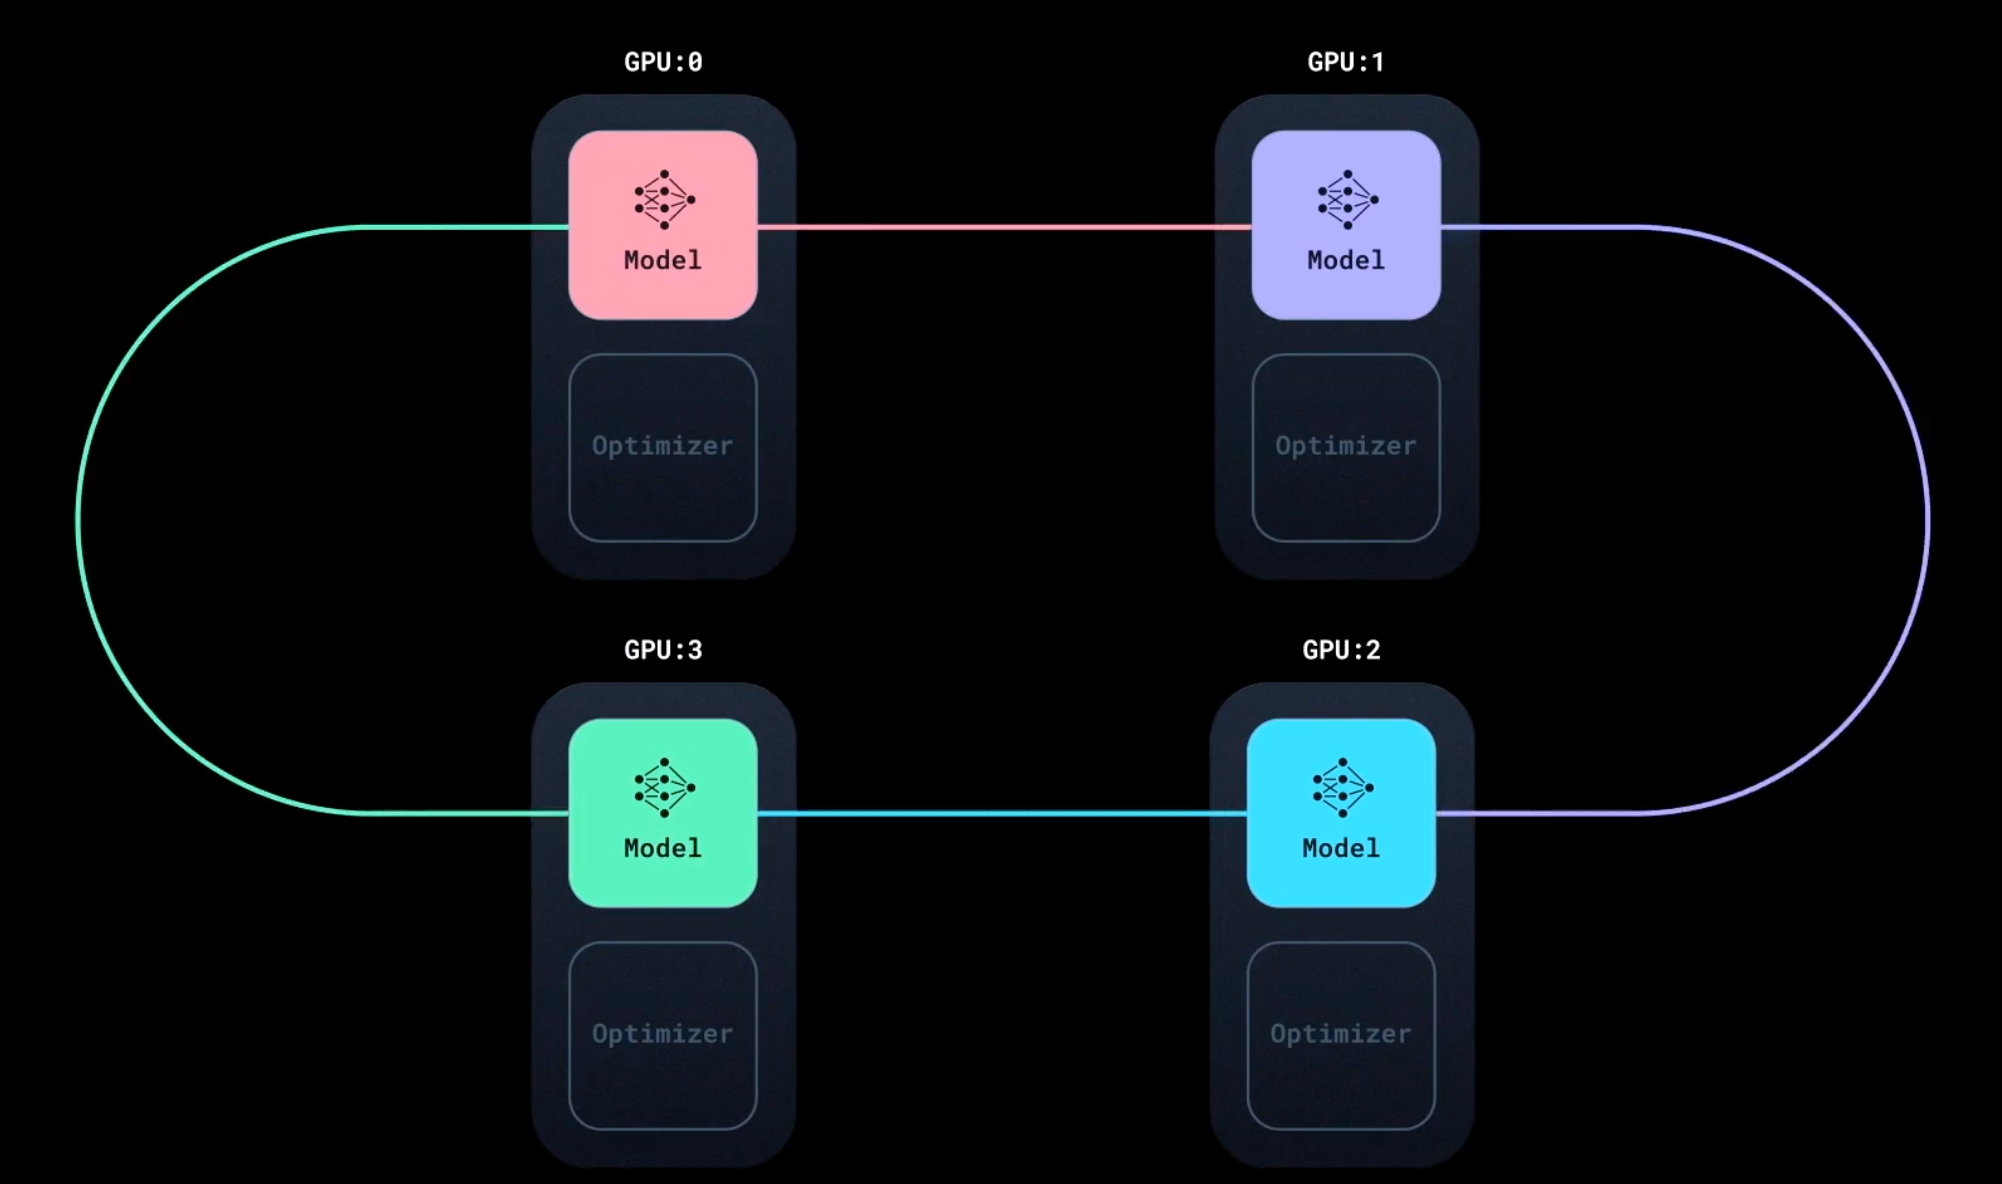

In [6]:
Image('../imgs/syn-gpus.png', width=600)

- 如上图所示，ring all-reduce algorithm
    - 首先会将所有的 gpu cards 连成一个 ring
    - 其同步过程，不需要等待所有的卡都计算完一轮梯度，
    - 经过这个同步过程之后，所有的卡的 models/optimizers 就都会保持一致的状态；

### Ring AllReduce algorithm

- 李沐：参数服务器；
    - https://d2l.ai/chapter_computational-performance/parameterserver.html
    - https://www.cs.cmu.edu/~muli/file/ps.pdf
- 计算和同步的几个过程
    - GPUs 分别计算损失（forward）和梯度（backward）
    - 梯度的聚合
    - （模型/优化器）参数的更新及广播（broadcast）；

- HPC（high performance computing）的基础算法
- Ring 环形拓扑结构
    - 百度提出来的；
    - 环形的，logical 的（逻辑的，非物理的）
    - 两个过程（基于环形逻辑拓扑）
        - scatter-reduce
        - all gather（broadcast）

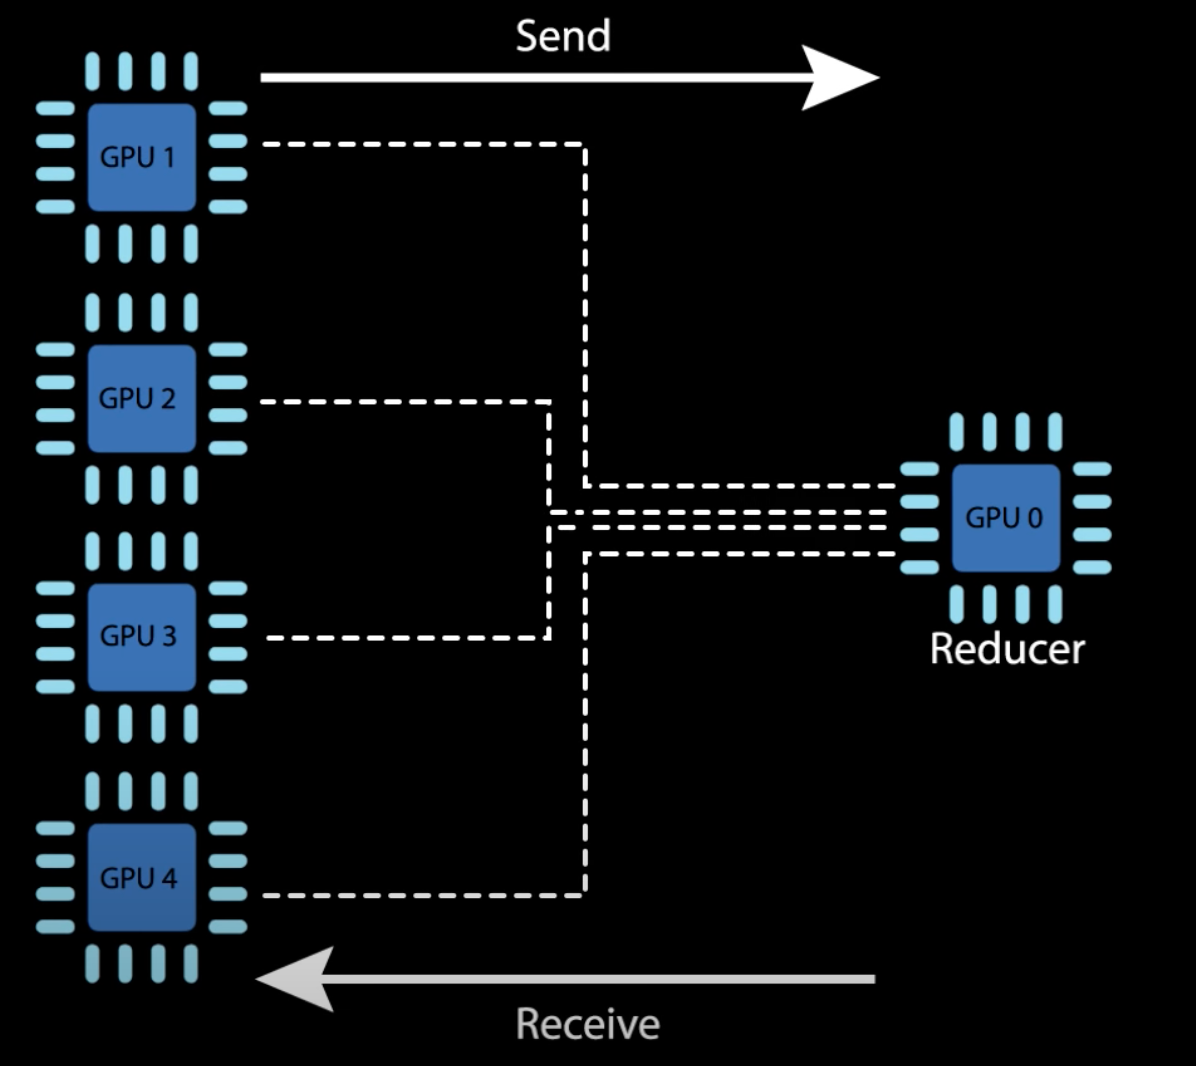

In [8]:
Image('../imgs/multigpus_1.png', width=400)

- send Data to only one GPU (reducer)
    - 将会成为通信的瓶颈

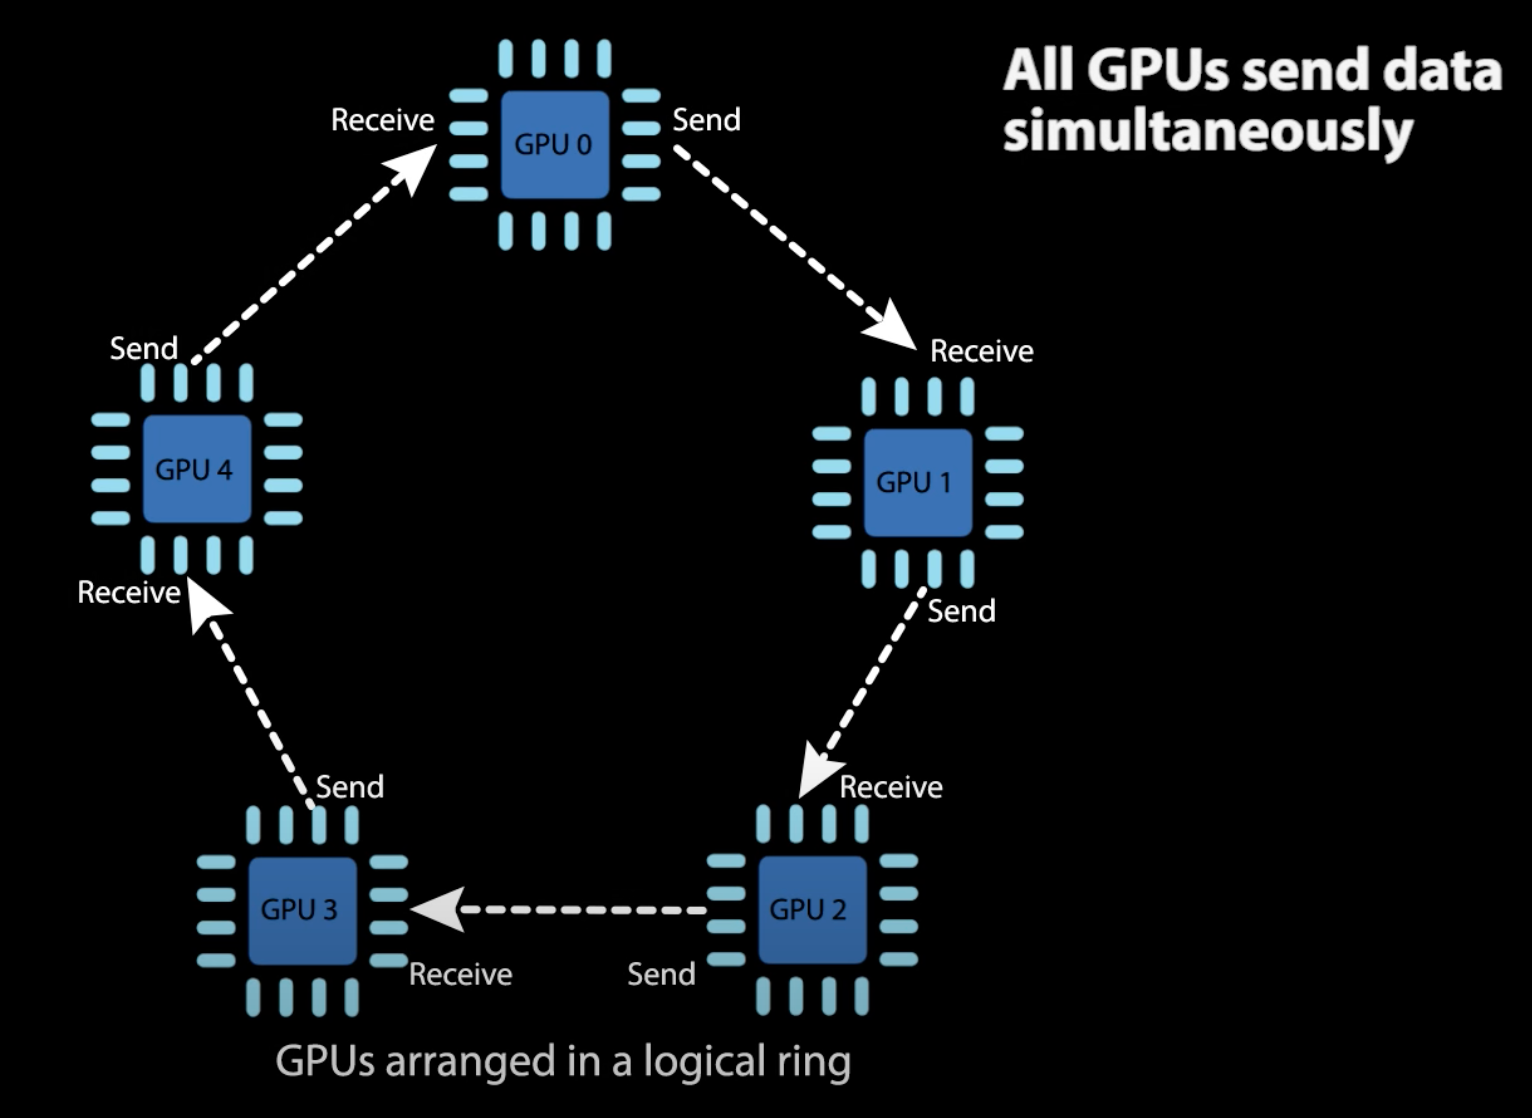

In [10]:
Image('../imgs/ring.png', width=400)

- sending data 花费的时间会更少；

## ddp 相关基本概念

### node, rank, world_size

> 不太严谨的理解

- world，world_size：
    - world：as a group containing all the processes for your distributed training.
        - 通常，每一个 gpu 代表一个进程（process）
        - world 内的 process 可以彼此通信，所以有 ddp 分布式训练的；
        
- rank
    - rank: is the unique ID given to a process, 进程级别的概念，rank 是为了标识、识别进程，因为进程间（process）需要通信；
    - local rank：is the a unique local ID for processes running in a single node

- node 理解为一个 server，2个servers（多机，机器之间需要通信）就是2个nodes
    - 比如每个 node/server/machine 各有4张卡（4 gpus），一个 2 个node/server；
    - world_size: 2\*4 == 8
    - ranks: [0, 1, 2, 3, 4, 5, 6, 7]
    - local_rank: [0, 1, 2, 3], [0, 1, 2, 3]
    

```
def ddp_setup(rank, world_size):
    """
    Args:
        rank: Unique identifier of each process
        world_size: Total number of processes
    """
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"
    init_process_group(backend="nccl", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)
```

## misc

```
if not torch.distributed.is_initialized():
    torch.distributed.init_process_group("nccl")
```

```
# torchrun --nproc_per_node 的参数
model_parallel_size = int(os.environ.get("WORLD_SIZE", 1))

local_rank = int(os.environ.get("LOCAL_RANK", 0))

torch.cuda.set_device(local_rank)
```